In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [39]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2645.3,540.3,1428.1,502.1,3.9,1.9
std,2.1,2.0,12.6,2201.8,430.1,1178.1,393.5,1.9,0.6
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1448.8,295.0,781.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2119.0,431.0,1155.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3145.2,645.0,1715.2,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,4.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2639.6,537.3,1433.0,499.0,3.9,1.9
std,2.2,2.0,12.5,2126.7,400.0,1071.8,362.0,1.9,0.6
min,32.6,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1485.0,303.0,810.0,286.0,2.6,1.5
50%,34.3,-118.5,29.0,2148.5,442.0,1195.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,656.0,1740.2,608.0,4.7,2.3
max,41.9,-114.7,52.0,30405.0,4386.0,12873.0,3933.0,15.0,4.0


Training targets summary:


,median_house_value
count,12000.0
mean,195.4
std,92.0
min,15.0
25%,119.6
50%,180.6
75%,265.3
max,350.0


Validation targets summary:


,median_house_value
count,5000.0
mean,196.0
std,92.7
min,27.5
25%,118.9
50%,179.5
75%,264.3
max,350.0


In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.45
  period 02 : 0.45
  period 03 : 0.44
  period 04 : 0.45
  period 05 : 0.45
  period 06 : 0.44
  period 07 : 0.45
  period 08 : 0.44
  period 09 : 0.44
Model training finished.


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


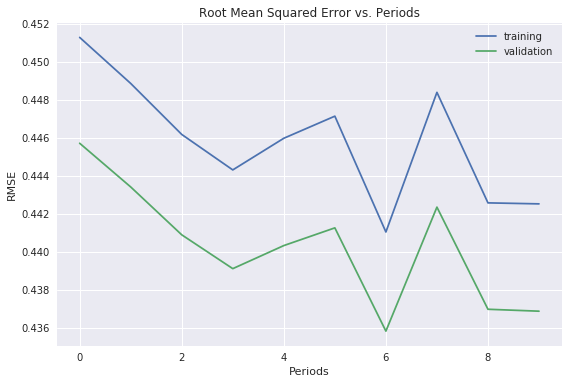

In [9]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

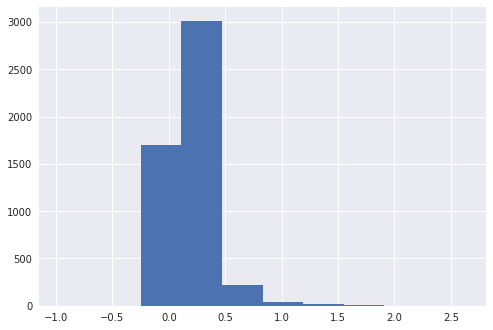

In [10]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.59
  period 02 : 0.57
  period 03 : 0.57
  period 04 : 0.55
  period 05 : 0.55
  period 06 : 0.54
  period 07 : 0.54
  period 08 : 0.53
  period 09 : 0.54
Model training finished.


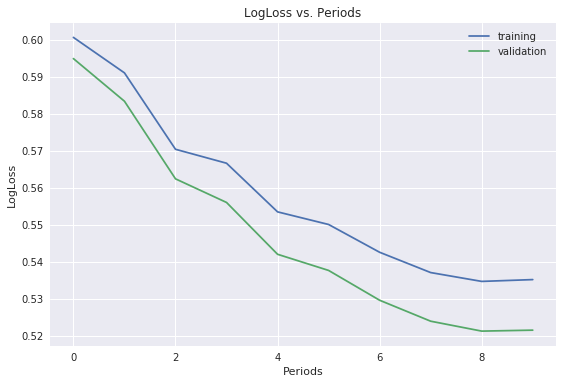

In [14]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss (on training data):"
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_log_loss)
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [15]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']

AUC on the validation set: 0.77
Accuracy on the validation set: 0.79


In [ ]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

Training model...
LogLoss (on training data):
  period 00 : 0.57
  period 01 : 0.54
  period 02 : 0.53
  period 03 : 0.53
  period 04 : 0.53
  period 05 : 0.52
  period 06 : 0.52
  period 07 : 0.52
  period 08 : 0.52
  period 09 : 0.52
Model training finished.
AUC on the validation set: 0.78
Accuracy on the validation set: 0.77


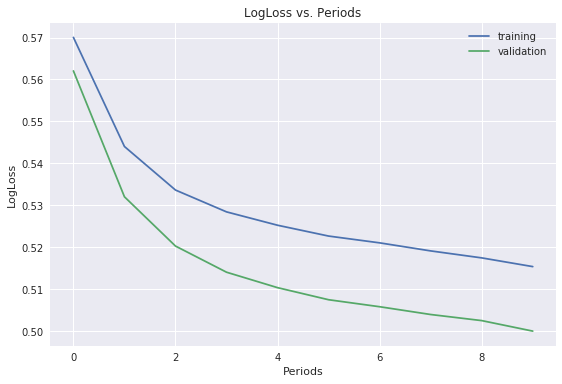

In [17]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=1000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']

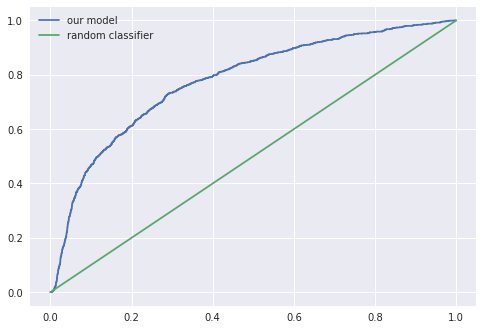

In [18]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

In [20]:
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2645.3,540.3,1428.1,502.1,3.9,2.0
std,2.1,2.0,12.6,2201.8,430.1,1178.1,393.5,1.9,1.2
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1448.8,295.0,781.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2119.0,431.0,1155.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3145.2,645.0,1715.2,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


In [21]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss (on validation data):"
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, validation_log_loss)
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [23]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

In [26]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in xrange(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

In [27]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """

  bucketized_households = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("households"),
    boundaries=get_quantile_based_buckets(training_examples["households"], 10))
  bucketized_longitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("longitude"),
    boundaries=get_quantile_based_buckets(training_examples["longitude"], 50))
  bucketized_latitude = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("latitude"),
    boundaries=get_quantile_based_buckets(training_examples["latitude"], 50))
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("housing_median_age"),
    boundaries=get_quantile_based_buckets(
      training_examples["housing_median_age"], 10))
  bucketized_total_rooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_rooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_rooms"], 10))
  bucketized_total_bedrooms = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("total_bedrooms"),
    boundaries=get_quantile_based_buckets(training_examples["total_bedrooms"], 10))
  bucketized_population = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("population"),
    boundaries=get_quantile_based_buckets(training_examples["population"], 10))
  bucketized_median_income = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("median_income"),
    boundaries=get_quantile_based_buckets(training_examples["median_income"], 10))
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column("rooms_per_person"),
    boundaries=get_quantile_based_buckets(
      training_examples["rooms_per_person"], 10))

  long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

  feature_columns = set([
    long_x_lat,
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_total_rooms,
    bucketized_total_bedrooms,
    bucketized_population,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Training model...
LogLoss (on validation data):
  period 00 : 0.31
  period 01 : 0.28
  period 02 : 0.26
  period 03 : 0.25
  period 04 : 0.25
  period 05 : 0.24
  period 06 : 0.24
Model training finished.
Model size: 750


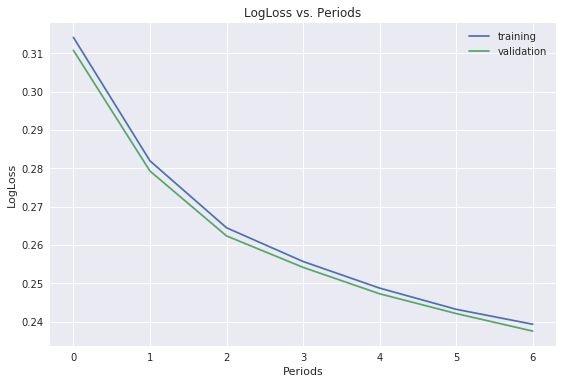

In [28]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.1,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print "Model size:", model_size(linear_classifier)

In [30]:
 def plot_auc():
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

  print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
  print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']
  validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  # Get just the probabilities for the positive class.
  validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      validation_targets, validation_probabilities)
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  _ = plt.legend(loc=2)

Training model...
LogLoss (on validation data):
  period 00 : 0.32
  period 01 : 0.28
  period 02 : 0.26
  period 03 : 0.26
  period 04 : 0.25
  period 05 : 0.25
  period 06 : 0.24
Model training finished.
Model size: 711


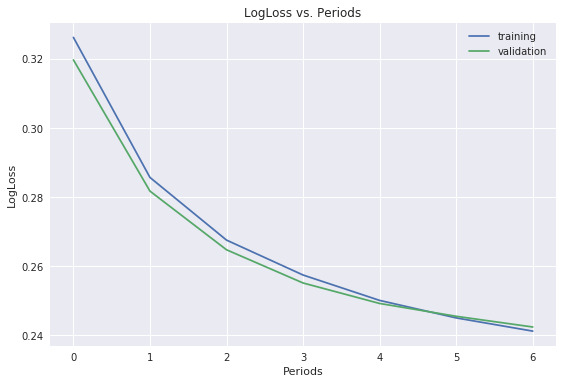

In [31]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.2,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print "Model size:", model_size(linear_classifier)

AUC on the validation set: 0.95
Accuracy on the validation set: 0.90


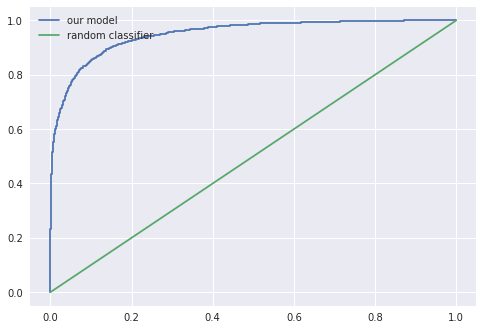

In [32]:
plot_auc()

In [42]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  processed_features['rooms_per_person'] = processed_features['rooms_per_person'].apply(lambda x: min(x, 4))
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [43]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2645.3,540.3,1428.1,502.1,3.9,1.9
std,2.1,2.0,12.6,2201.8,430.1,1178.1,393.5,1.9,0.6
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1448.8,295.0,781.8,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2119.0,431.0,1155.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3145.2,645.0,1715.2,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,4.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2639.6,537.3,1433.0,499.0,3.9,1.9
std,2.2,2.0,12.5,2126.7,400.0,1071.8,362.0,1.9,0.6
min,32.6,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1485.0,303.0,810.0,286.0,2.6,1.5
50%,34.3,-118.5,29.0,2148.5,442.0,1195.0,414.0,3.5,1.9
75%,37.7,-118.0,37.0,3166.0,656.0,1740.2,608.0,4.7,2.3
max,41.9,-114.7,52.0,30405.0,4386.0,12873.0,3933.0,15.0,4.0


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Training model...
LogLoss (on validation data):
  period 00 : 0.32
  period 01 : 0.28
  period 02 : 0.27
  period 03 : 0.26
  period 04 : 0.25
  period 05 : 0.24
  period 06 : 0.24
Model training finished.
Model size: 696


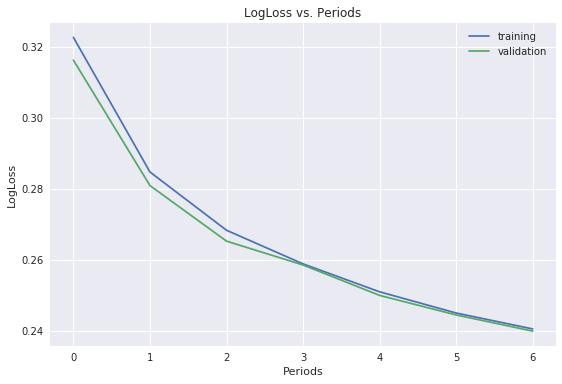

In [44]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    # TWEAK THE REGULARIZATION VALUE BELOW
    regularization_strength=0.3,
    steps=300,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print "Model size:", model_size(linear_classifier)

AUC on the validation set: 0.95
Accuracy on the validation set: 0.90


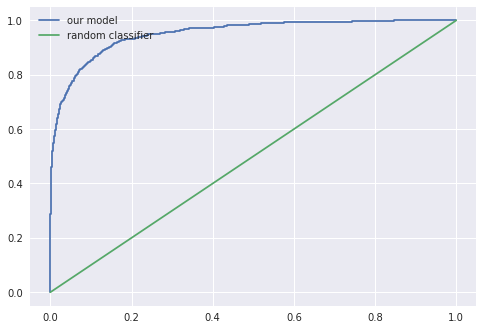

In [45]:
plot_auc()